# Minimal model for action potential, potassium current and calcium dynamics

- Most of the constants are unphysical, so take with a grain of salt!

Loads a bunch of libraries 

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np 
import matplotlib.pylab as plt

## Currents

In [490]:
def iKChannel(
    Vm, # membrane potential  
    E,  # current 
    params):
    gCond = 3.       # conductivity
    vDiff = Vm - E   # difference between Nernst potential for K ion and the membrane potential 
    #IV = Vm+90  # very crude approx for IV 
    #if IV>10: IV = 10  # set a maximum value for the the current 
    iKChannel = gCond * vDiff 
    return iKChannel


# Makes an abrupt increase, then relaxes in a linear fashion
def iAP(t):
    current = -300. # [mA]
    start=10.
    finishHat=90.
    finishLin=175.
    delta = finishLin-finishHat
    scale = (finishLin-t)/delta
    if t>start and t<finishHat:
        return current
    elif t>= finishHat and t<finishLin:
        return scale*current
    else:
        return 0 
    
def iCaPOpen(Vm):
    V50 = 50.
    n = 4
    pOpen = (1 + (V50/(Vm + 70))**n)**-1 
    return pOpen
    
    
def iCaChannel(Vm, E,params):
    vDiff = Vm - E
    iCaChannel =  params.gCa * iCaPOpen(Vm)* vDiff 
    return iCaChannel




### Ca functions 

- uptake (SERCA) and release
- Add rest, these contributions should be equal and opposite 
- If changing params.Vmax, you'll want to do the same to the params.leakRate in SRLeak()

In [491]:
def SERCA(caCyto,params):
    JSERCA = -params.Vmax/(1 + (params.sercaKD/caCyto)**6)
    return JSERCA
    
    
def SRLeak(caCyto,Vm,params):

    if Vm < -50:
      Jleak = params.leakRate
      #Jleak = params.leakRate/(1 + (0.5/0.1)**2)
    else:
      Jleak = 0.
        #print Jleak
    return Jleak    

### Constants 

### ODE integrator 

In [492]:

def dydt(y,t,params):
    P2Y12=0
    Vm, Ca = y
    
# currents, including G-protein dependent K channel activation 
    IK = iKChannel(Vm, Ek,params)
    ICa = iCaChannel(Vm, ECa,params)
    IAP = iAP(t)
    #ICa = iCaChannel(Vm,CaLig,params)
    #ILeak = iLeak(Vm,params)
    
    #INKA = params.INKA;
    conv = 0.005 # i to dCa conv factor 
    JCa = conv *  ICa
    JSERCA = SERCA(Ca, params)
    JLeak = SRLeak(Ca,Vm,params)
    
    # Membrane potential 
    dVm_dt = -(IK + ICa + IAP)/Cm;
    dCa_dt = JCa + JSERCA + JLeak
    return dVm_dt, dCa_dt

In [493]:
from scipy.integrate import odeint

## Simulator 

In [499]:
Ek = -70 # mV
ECa = 0. # mV 

class Params():
    def __init__(self):
      # serca parameters
      self.sercaKD = 0.30 # Ca concentration at which pump is 50%
      self.Vmax = 0.010   # turnover rate   
    
      # leak parameters 
      self.leakRate = 13e-5
        
      # Ca release channel current   
      self.gCa = 0.18
    
      # initial calcium concentration 
      self.Ca0 = 0.145 # uM 
params = Params()    


#params.gCa = 0.

Cm = 1.   # 
tEnd = 500.

In [500]:

ts = np.linspace(0,tEnd,10000)
Vm = -70 # mV

y0 = [Vm, params.Ca0] # , rhoKchannel,Gprot,CaLig,Ca]


ys = odeint(dydt,y0,ts,args=(params,))

/var/folders/4d/5k72012d6k962xflcjjdwkf00000gp/T/ipykernel_17640/1542759097.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  pOpen = (1 + (V50/(Vm + 70))**n)**-1


### Plot results of P Open



/var/folders/4d/5k72012d6k962xflcjjdwkf00000gp/T/ipykernel_17640/1542759097.py:31: RuntimeWarning: divide by zero encountered in true_divide
  pOpen = (1 + (V50/(Vm + 70))**n)**-1


Text(0.5, 0, 'V')

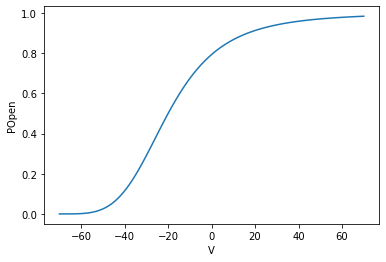

In [501]:
Vs = np.linspace(-70, 70,100)
plt.plot(Vs,iCaPOpen(Vs))
plt.ylabel("POpen")
plt.xlabel("V")

### Plot simulation results 

/var/folders/4d/5k72012d6k962xflcjjdwkf00000gp/T/ipykernel_17640/1542759097.py:31: RuntimeWarning: divide by zero encountered in true_divide
  pOpen = (1 + (V50/(Vm + 70))**n)**-1


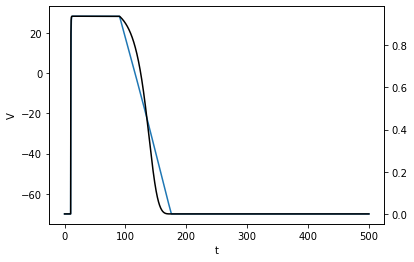

In [502]:
fig,ax = plt.subplots(1)
Vms= ys[:,0 ]
ax.plot(ts, Vms)

ax.set_ylabel("V")
ax.set_xlabel("t")

axr = ax.twinx()
pOs = iCaPOpen(Vms)

axr.plot(ts,pOs,'k')

Text(0, 0.5, 'Ca')

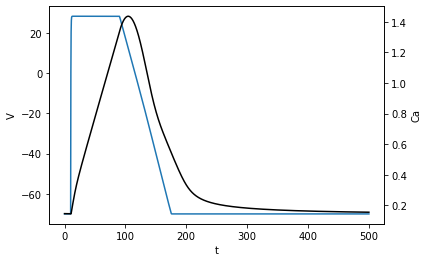

In [503]:
fig,ax = plt.subplots(1)

cas = ys[:,1 ]

ax.plot(ts, ys[:,0 ])
ax.set_ylabel("V")
ax.set_xlabel("t")

axr = ax.twinx()
axr.plot(ts,cas,"k")
plt.ylabel("Ca")

### Here we are creating an example where we fit the model to real data

- Data was recorded at 1 Hz, so the 400 frames here corresponds to 400 sec ---> 7 min = 420 sec ~ 400 sec  
- we also normalize the data for simplicity
- will assume that the useful data starts after thge 120th frame 
- 'transient' from model starts at t=10, so having data ts start from then too  

In [504]:
data = np.loadtxt("/Users/huskeypm/Downloads/B12.csv",skiprows=1, delimiter=',')
print( np.shape(data) )
frInit = 120
dts = data[frInit:,0]  # 400 sec
dts -= (frInit-10) 



dcas = data[frInit:,1]
dcas-= np.min(dcas)
dcas/= np.max(dcas)



(421, 2)


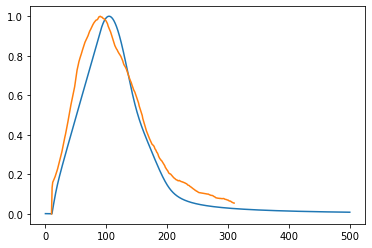

In [505]:
ncas = cas - np.min(cas)
ncas = ncas/np.max(ncas)
#ncas = cas
plt.plot(ts,ncas)

plt.plot(dts,dcas)
